# 3주차 심화과제
# - GPT로 뉴스 기사 분류 모델 학습하기

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 89.4 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.35.16
    Uninstalling botocore-1.35.16:
      Successfully uninstalled botocore-1.35.16
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.0 requires botocore<1.35.17,>=1.35.16, but you have botocore 1.29.165 which is incompatible.


그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

# tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'openai-gpt') # distilbert-base-uncased로 설정한 tokenizer와 encoder를 openai-gpt로 변경
tokenizer = AutoTokenizer.from_pretrained("openai-gpt", clean_up_tokenization_spaces=True)

tokenizer.pad_token = tokenizer.unk_token #GPT의 tokenizer는 padding token이 없어, 다음 코드로 padding token을 추가

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [3]:
ds = load_dataset("fancyzhx/ag_news")


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True,  max_length=max_len).input_ids) #Truncation과 관련된 부분들을 지움
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [4]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'openai-gpt')
model

/opt/conda/lib/python3.10/site-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

OpenAIGPTModel(
  (tokens_embed): Embedding(40478, 768)
  (positions_embed): Embedding(512, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x Block(
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
  )
)

# Classify 할 때 사용하는 token representation 변경
  - 현재 `TextClassifier`는 첫 번째 token의 representation으로 label을 예측하고 있습니다.
  - 하지만 GPT의 pre-train 방식을 생각하면 첫 번째 token으로 label을 예측하면 안됩니다.
  - GPT의 pre-train 방식과 이전 RNN 실습에서 아이디어를 얻어 classify를 할 때 사용하는 token representation을 적절하게 변경하시면 됩니다.

In [5]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'openai-gpt')
    self.classifier = nn.Linear(768, 4)

  def forward(self, x):
    x = self.encoder(x)['last_hidden_state']
    x = self.classifier(x[:, -1]) # 마지막토큰의 representation 사용

    return x


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [6]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [7]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1) # argmax를 사용하여 예측 클래스 계산


    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch   0 | Train Loss: 1325.7591017186642
=========> Train acc: 0.814 | Test acc: 0.815
Epoch   1 | Train Loss: 1113.1092534959316
=========> Train acc: 0.839 | Test acc: 0.836
Epoch   2 | Train Loss: 1084.4989740252495
=========> Train acc: 0.806 | Test acc: 0.804
Epoch   3 | Train Loss: 1073.3920726180077
=========> Train acc: 0.834 | Test acc: 0.833
Epoch   4 | Train Loss: 1064.231175094843
=========> Train acc: 0.846 | Test acc: 0.840
Epoch   5 | Train Loss: 1068.6095151305199
=========> Train acc: 0.842 | Test acc: 0.837
Epoch   6 | Train Loss: 1066.6803514361382
=========> Train acc: 0.844 | Test acc: 0.840
Epoch   7 | Train Loss: 1056.5174745321274
=========> Train acc: 0.834 | Test acc: 0.831
Epoch   8 | Train Loss: 1061.5615582466125
=========> Train acc: 0.836 | Test acc: 0.832
Epoch   9 | Train Loss: 1053.7706342041492
=========> Train acc: 0.847 | Test acc: 0.842


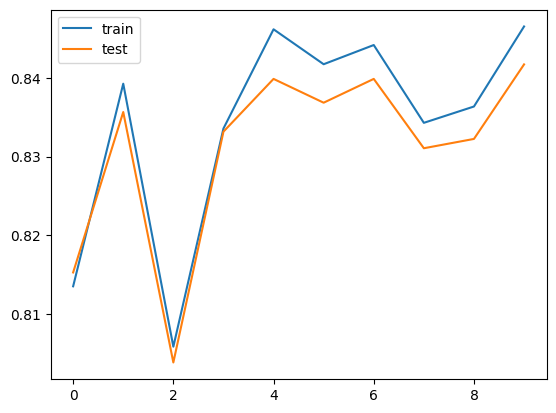

In [8]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt


lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss() # nn.CrossEntropyLoss()로 변경

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10
train_accs, test_accs = [], []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

plot_acc(train_accs, test_accs)

Loss가 잘 떨어지고, 이전에 우리가 구현한 Transformer보다 더 빨리 수렴하는 것을 알 수 있습니다.